# Kaggle March Machine Learning Mania 2025 
## NCAA Basketball Tournament Outcome Prediction
### Project Overview
- This project aims to predict the outcomes of NCAA Division I Basketball Tournament matchups for Kaggle’s March Machine Learning Mania 2025 competition. The objective is to forecast the probabilities of every possible matchup using historical performance data, team statistics, and tournament-specific factors.

##### Objective
- Predict the probability that one team will win over another in a tournament matchup.
- Use a stacking model to combine the predictive power of XGBoost, Random Forest, and LightGBM for better accuracy.
- Optimize for Brier Score, the official evaluation metric for the competition.

##### Data Overview
- Training Data: Historical matchup outcomes with team statistics and performance metrics.
- Test Data: Upcoming matchups for the 2025 tournament (submission file will contain predicted probabilities).

###### Features:
 - 'RollingWinMargin' - Rolling average of win margin over games check performance consistency and momentum
 - 'NumOT' - NumOT Number of overtime periods in the game showcasing resilience and ability to perform under pressure
 - 'OrdinalRank' - OrdinalRank Team ranking based on historical performance indicating team strength based on historical data
 - 'WTeamID' - WTeamID Encodes the winning team ID Essential for mapping outcomes to matchups
 - 'LTeamID' - LTeamID Encodes the losing team ID Essential for mapping outcomes to matchups
 - 'Season' - Season The year of the tournament captures season-specific variations (e.g., roster changes)
 - 'DayNum' - DayNum Day of the tournament game reflects the impact of schedule and rest days
 - 'SeedNum_x_HomeAdvantage' - SeedNum_x_HomeAdvantage Combines seed ranking and home advantage of higher-seeded teams playing

###### Why These Features Are Effective:
1. Direct Impact on Outcome - Each feature has a clear and logical connection to the game result.
2. Simplicity and Generalization - Avoids overfitting by focusing on meaningful, interpretable metrics.
3. Tournament Relevance - Captures key aspects of tournament play (momentum, ranking, and fatigue).
4. Balanced Scope - Avoids feature explosion while retaining enough detail for predictive power.

##### Evaluation
Evaluate performance using:
- Accuracy
- F1 Score
- Precision
- Recall
- ROC AUC
- Brier Score
- Log Loss


Best Performance:
#### Metric	Score
- Accuracy	0.7343
- F1 Score	0.6571
- Precision	0.6864
- Recall	0.6303
- ROC AUC	0.8138
- Brier Score	0.1725
- Log Loss	0.5123


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
DATA_PATH = "C:/Users/91788/march-mania"

#load Men's Data
teams = pd.read_csv(f"{DATA_PATH}/MTeams.csv")
seasons = pd.read_csv(f"{DATA_PATH}/MSeasons.csv")
seeds = pd.read_csv(f"{DATA_PATH}/MNCAATourneySeeds.csv")
regular_results = pd.read_csv(f"{DATA_PATH}/MRegularSeasonCompactResults.csv")
tourney_results = pd.read_csv(f"{DATA_PATH}/MNCAATourneyCompactResults.csv")
detailed_results = pd.read_csv(f"{DATA_PATH}/MRegularSeasonDetailedResults.csv")
massey_ordinals = pd.read_csv(f"{DATA_PATH}/MMasseyOrdinals.csv")

# Load Women’s Data
w_teams = pd.read_csv(f"{DATA_PATH}/WTeams.csv")
w_seasons = pd.read_csv(f"{DATA_PATH}/WSeasons.csv")
w_seeds = pd.read_csv(f"{DATA_PATH}/WNCAATourneySeeds.csv")
w_regular_results = pd.read_csv(f"{DATA_PATH}/WRegularSeasonCompactResults.csv")
w_tourney_results = pd.read_csv(f"{DATA_PATH}/WNCAATourneyCompactResults.csv")
w_detailed_results = pd.read_csv(f"{DATA_PATH}/WRegularSeasonDetailedResults.csv")


# Basic Understanding and Exploration

In [12]:


display(teams.head())


,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2025
1,1102,Air Force,1985,2025
2,1103,Akron,1985,2025
3,1104,Alabama,1985,2025
4,1105,Alabama A&M,2000,2025


In [13]:
# Number of rows and columns
print("Teams Shape:", teams.shape)
print("Seasons Shape:", seasons.shape)
print("Seeds Shape:", seeds.shape)
print("Regular Results Shape:", regular_results.shape)
print("Tourney Results Shape:", tourney_results.shape)
print("Detailed Results Shape:", detailed_results.shape)
print("Massey Ordinals Shape:", massey_ordinals.shape)

# General Info
teams.info()
seasons.info()
seeds.info()
regular_results.info()
tourney_results.info()
detailed_results.info()
massey_ordinals.info()


Teams Shape: (380, 4)
Seasons Shape: (41, 6)
Seeds Shape: (2558, 3)
Regular Results Shape: (192497, 8)
Tourney Results Shape: (2518, 8)
Detailed Results Shape: (118449, 34)
Massey Ordinals Shape: (5526389, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TeamID         380 non-null    int64 
 1   TeamName       380 non-null    object
 2   FirstD1Season  380 non-null    int64 
 3   LastD1Season   380 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 12.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Season   41 non-null     int64 
 1   DayZero  41 non-null     object
 2   RegionW  41 non-null     object
 3   RegionX  41 non-null     object
 4   RegionY  41 non-null     object
 5   RegionZ  41 

In [16]:
print(teams.describe())
print(seasons.describe())
print(seeds.describe())
print(regular_results.describe())
print(tourney_results.describe())
print(detailed_results.describe())
print(massey_ordinals.describe())

            TeamID  FirstD1Season  LastD1Season
count   380.000000     380.000000    380.000000
mean   1290.500000    1989.618421   2023.952632
std     109.840794       9.755814      5.686894
min    1101.000000    1985.000000   1985.000000
25%    1195.750000    1985.000000   2025.000000
50%    1290.500000    1985.000000   2025.000000
75%    1385.250000    1986.250000   2025.000000
max    1480.000000    2025.000000   2025.000000
            Season
count    41.000000
mean   2005.000000
std      11.979149
min    1985.000000
25%    1995.000000
50%    2005.000000
75%    2015.000000
max    2025.000000
            Season       TeamID
count  2558.000000  2558.000000
mean   2004.376466  1290.900704
std      11.449682   103.447343
min    1985.000000  1101.000000
25%    1994.250000  1208.000000
50%    2004.000000  1285.000000
75%    2014.000000  1387.000000
max    2024.000000  1463.000000
              Season         DayNum        WTeamID         WScore  \
count  192497.000000  192497.000000  192

Competition details:

- Team IDs – TeamID is a unique identifier used across multiple files to connect team information, game results, and rankings.
- Season Data – Season allows you to link game stats, team performance, and seedings within the same season.
- Game Outcomes – WTeamID and LTeamID in game result files naturally link to team and seed data.
- Rankings – OrdinalRank from Massey rankings reflects team strength and connects via Season and TeamID.


Logic for Merging
- Team-Level Data – TeamID is a unique identifier available in team info, rankings, and game outcomes.
- Seasonal Data – Season allows for consistency across performance trends and seeding data.
- Game Outcomes – WTeamID and LTeamID link game results to team details.
- Performance Metrics – Massey rankings and detailed stats reflect team strength and efficiency.

In [58]:
# Merge Teams and Seasons
team_season = pd.merge(teams, seasons, how='inner', left_on='FirstD1Season', right_on='Season')
w_team_season = pd.merge(w_teams, w_seasons, how='inner', left_on='TeamID', right_on='Season')

In [59]:
# Merge Regular Season Results with Seeds
regular_season = pd.merge(regular_results, seeds, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
w_regular_season = pd.merge(w_regular_results, w_seeds, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')

In [60]:
# Merge Tournament Data with Team Info
tourney_data = pd.merge(tourney_results, seeds, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
w_tourney_data = pd.merge(w_tourney_results, w_seeds, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')

In [61]:
# no ranking file - w
rankings = massey_ordinals.groupby(['Season', 'TeamID'])['OrdinalRank'].mean().reset_index()
combined_data = pd.merge(regular_season, rankings, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')


In [62]:
#final_data = combined_data[['Season', 'WTeamID', 'LTeamID', 'WScore', 'LScore', 'Seed', 'OrdinalRank']]
#w_final_data = w_regular_season[['Season', 'WTeamID', 'LTeamID', 'WScore', 'LScore', 'Seed']]

In [63]:
# Include WLoc in the final data after merging
final_data = pd.merge(regular_results[['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc']],
                      seeds[['Season', 'TeamID', 'Seed']],
                      left_on=['Season', 'WTeamID'],
                      right_on=['Season', 'TeamID'],
                      how='left')

w_final_data = pd.merge(w_regular_results[['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc']],
                        w_seeds[['Season', 'TeamID', 'Seed']],
                        left_on=['Season', 'WTeamID'],
                        right_on=['Season', 'TeamID'],
                        how='left')

In [64]:
# Men’s teams
print(teams.head())
print(teams.describe(include='all'))
print(teams.nunique())

# Women’s teams
print(w_teams.head())
print(w_teams.describe(include='all'))
print(w_teams.nunique())

   TeamID     TeamName  FirstD1Season  LastD1Season
0    1101  Abilene Chr           2014          2025
1    1102    Air Force           1985          2025
2    1103        Akron           1985          2025
3    1104      Alabama           1985          2025
4    1105  Alabama A&M           2000          2025
             TeamID     TeamName  FirstD1Season  LastD1Season
count    380.000000          380     380.000000    380.000000
unique          NaN          380            NaN           NaN
top             NaN  Abilene Chr            NaN           NaN
freq            NaN            1            NaN           NaN
mean    1290.500000          NaN    1989.618421   2023.952632
std      109.840794          NaN       9.755814      5.686894
min     1101.000000          NaN    1985.000000   1985.000000
25%     1195.750000          NaN    1985.000000   2025.000000
50%     1290.500000          NaN    1985.000000   2025.000000
75%     1385.250000          NaN    1986.250000   2025.000000
max   

In [65]:
# Check missing values
print("Missing Values (Men's Data):")
print(final_data.isnull().sum())

print("Missing Values (Women's Data):")
print(w_final_data.isnull().sum())


Missing Values (Men's Data):
Season          0
DayNum          0
WTeamID         0
WScore          0
LTeamID         0
LScore          0
WLoc            0
TeamID     136066
Seed       136066
dtype: int64
Missing Values (Women's Data):
Season         0
DayNum         0
WTeamID        0
WScore         0
LTeamID        0
LScore         0
WLoc           0
TeamID     98506
Seed       98506
dtype: int64


In [66]:
# Check for duplicates
print("Duplicate Rows in Men's Data:", final_data.duplicated().sum())
print("Duplicate Rows in Women's Data:", w_final_data.duplicated().sum())


Duplicate Rows in Men's Data: 0
Duplicate Rows in Women's Data: 0


In [67]:
print(seeds['Seed'].value_counts())


W01     39
Y14     39
X15     39
Y01     39
Y02     39
        ..
Z13a     1
Z14a     1
X12b     1
X12a     1
Z10b     1
Name: Seed, Length: 94, dtype: int64


In [68]:
print(w_seeds['Seed'].value_counts())


W01     26
X15     26
Y02     26
Y03     26
Y04     26
        ..
W11a     1
Y11a     1
X11b     1
X11a     1
Z12b     1
Name: Seed, Length: 80, dtype: int64


In [69]:
print(regular_results['WLoc'].value_counts())
print(w_regular_results['WLoc'].value_counts())


H    113775
A     59179
N     19543
Name: WLoc, dtype: int64
H    77502
A    49167
N     9959
Name: WLoc, dtype: int64


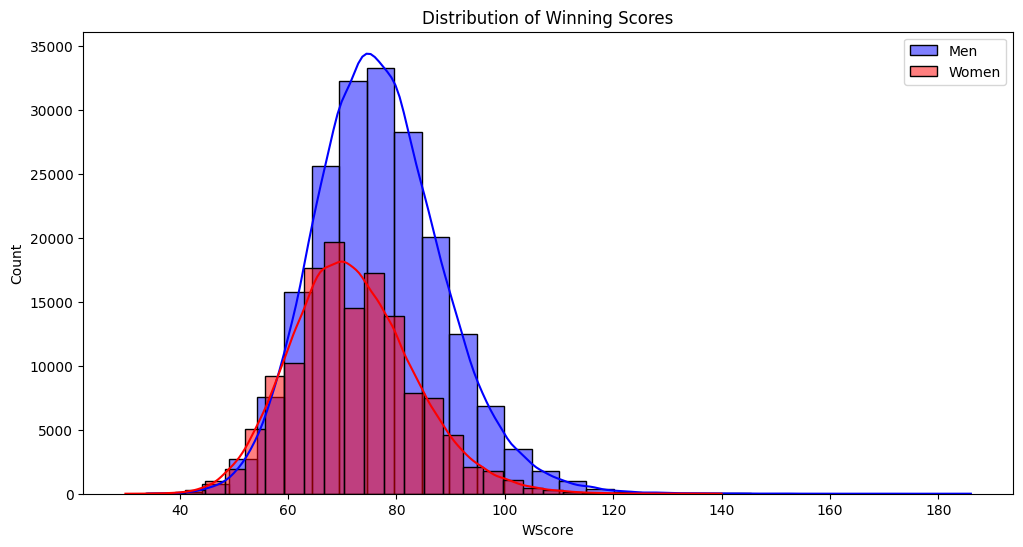

In [70]:
plt.figure(figsize=(12, 6))
sns.histplot(final_data['WScore'], bins=30, kde=True, color='blue', label='Men')
sns.histplot(w_final_data['WScore'], bins=30, kde=True, color='red', label='Women')
plt.title('Distribution of Winning Scores')
plt.legend()
plt.show()


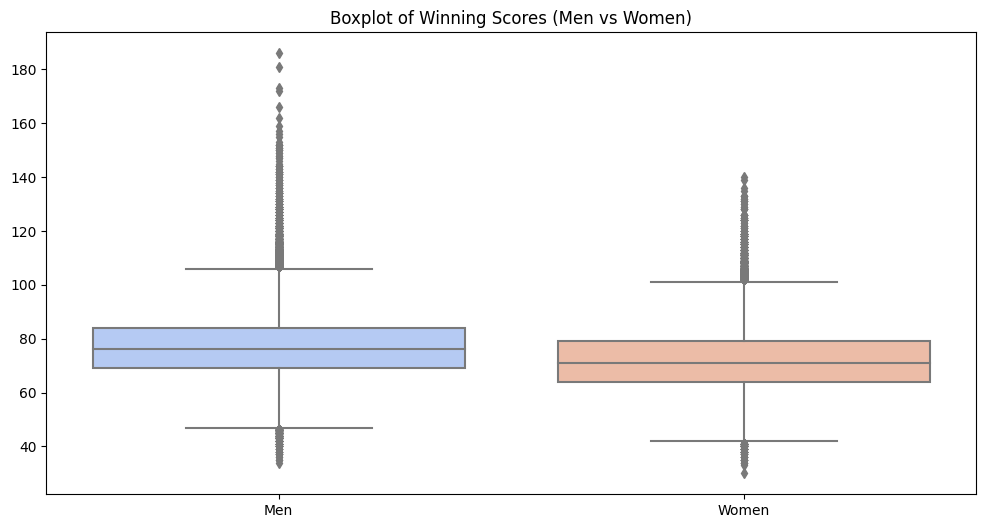

In [71]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=[final_data['WScore'], w_final_data['WScore']], palette='coolwarm')
plt.xticks([0, 1], ['Men', 'Women'])
plt.title('Boxplot of Winning Scores (Men vs Women)')
plt.show()


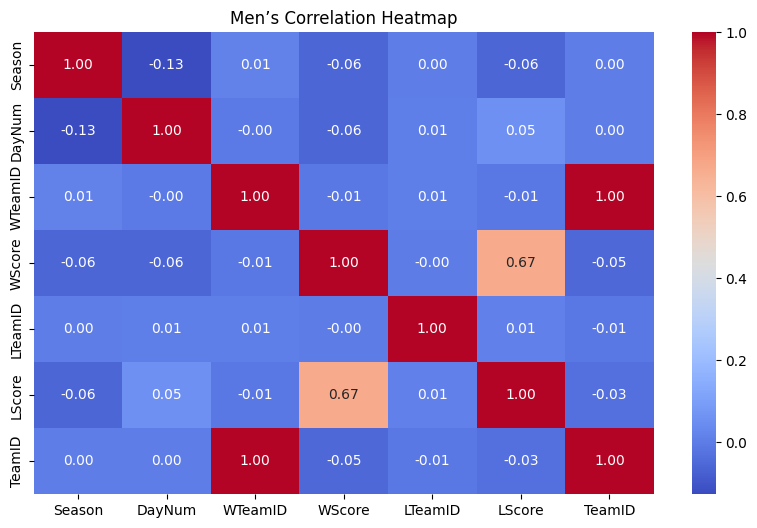

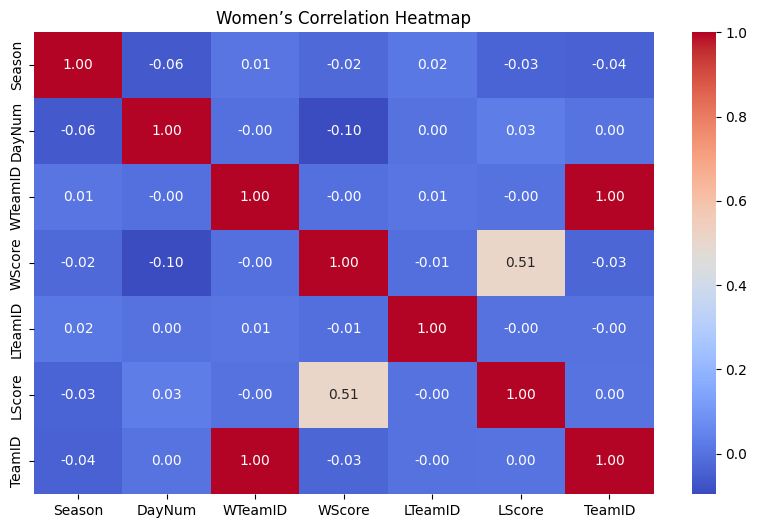

In [72]:
plt.figure(figsize=(10, 6))
sns.heatmap(final_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Men’s Correlation Heatmap')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(w_final_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Women’s Correlation Heatmap')
plt.show()


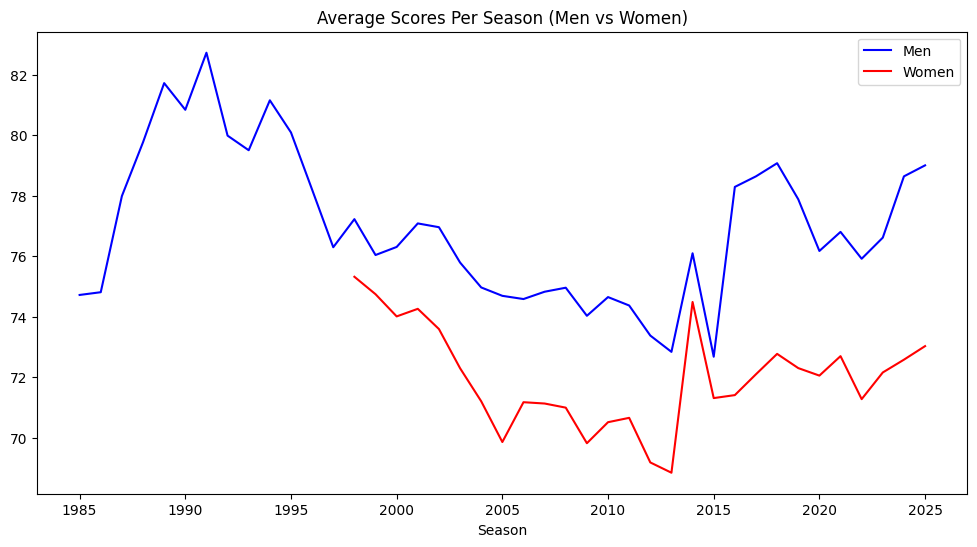

In [73]:
avg_men_score = final_data.groupby('Season')['WScore'].mean()
avg_women_score = w_final_data.groupby('Season')['WScore'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_men_score.index, y=avg_men_score.values, label='Men', color='blue')
sns.lineplot(x=avg_women_score.index, y=avg_women_score.values, label='Women', color='red')
plt.title('Average Scores Per Season (Men vs Women)')
plt.show()


In [74]:
Q1 = final_data['WScore'].quantile(0.25)
Q3 = final_data['WScore'].quantile(0.75)
IQR = Q3 - Q1

outliers_men = final_data[(final_data['WScore'] < Q1 - 1.5 * IQR) | 
                          (final_data['WScore'] > Q3 + 1.5 * IQR)]
print(f"Outliers in Men's WScore: {outliers_men.shape[0]}")

Q1_w = w_final_data['WScore'].quantile(0.25)
Q3_w = w_final_data['WScore'].quantile(0.75)
IQR_w = Q3_w - Q1_w

outliers_women = w_final_data[(w_final_data['WScore'] < Q1_w - 1.5 * IQR_w) | 
                              (w_final_data['WScore'] > Q3_w + 1.5 * IQR_w)]
print(f"Outliers in Women's WScore: {outliers_women.shape[0]}")


Outliers in Men's WScore: 2967
Outliers in Women's WScore: 1636


In [75]:
final_data['Score_Diff'] = final_data['WScore'] - final_data['LScore']
w_final_data['Score_Diff'] = w_final_data['WScore'] - w_final_data['LScore']


In [76]:
win_rate = final_data['WTeamID'].value_counts() / (final_data['WTeamID'].value_counts() + final_data['LTeamID'].value_counts())
final_data['WinRate'] = final_data['WTeamID'].map(win_rate)

win_rate_w = w_final_data['WTeamID'].value_counts() / (w_final_data['WTeamID'].value_counts() + w_final_data['LTeamID'].value_counts())
w_final_data['WinRate'] = w_final_data['WTeamID'].map(win_rate_w)


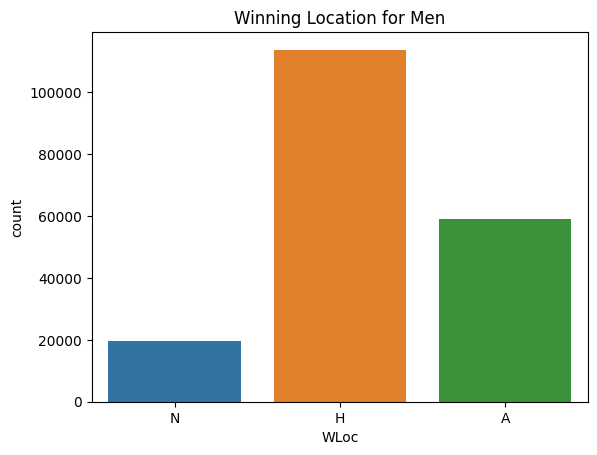

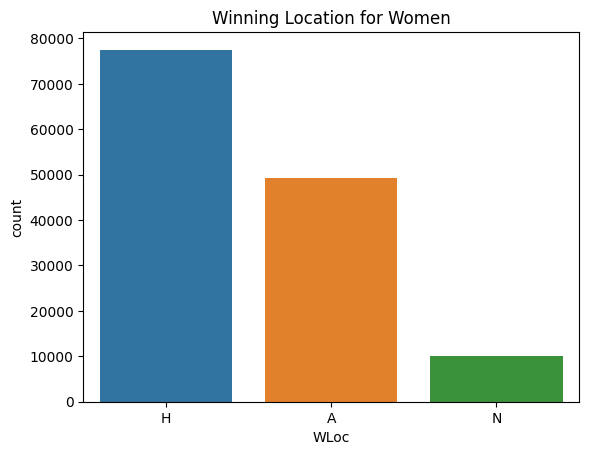

In [77]:
sns.countplot(data=regular_results, x='WLoc')
plt.title('Winning Location for Men')
plt.show()

sns.countplot(data=w_regular_results, x='WLoc')
plt.title('Winning Location for Women')
plt.show()


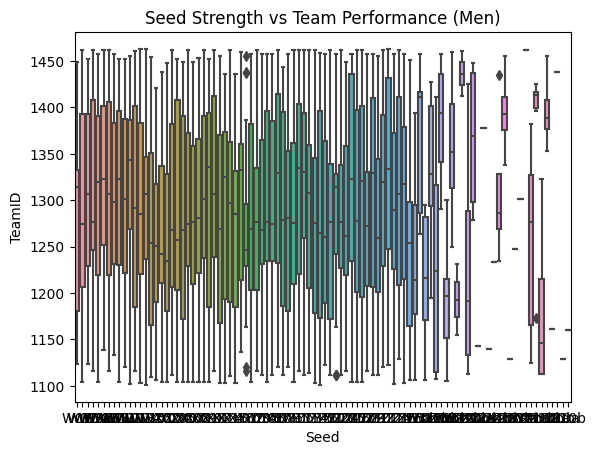

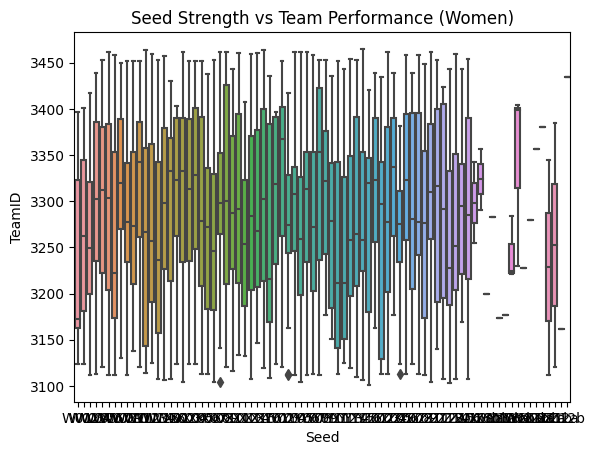

In [78]:
sns.boxplot(data=seeds, x='Seed', y='TeamID')
plt.title('Seed Strength vs Team Performance (Men)')
plt.show()

sns.boxplot(data=w_seeds, x='Seed', y='TeamID')
plt.title('Seed Strength vs Team Performance (Women)')
plt.show()


- Men's and Women's datasets have similar structures.
- Women's data lacks ranking data (WMasseyOrdinals.csv) — need to decide how to handle this for predictive modeling.
- Some fields are specific to teams, games, and tournament results, and some overlap across the two datasets.

- Outliers mostly concentrated at the higher end of the score range — needs deeper analysis on whether to remove, transform, or keep them.
Extremely high scores could be real and meaningful, so we probably shouldn't remove them outright — capping them at the 99th percentile seems like the best approach.

In [80]:
# Outlier capping
cap_men = final_data['WScore'].quantile(0.99)
cap_women = w_final_data['WScore'].quantile(0.99)

# Apply capping
final_data['WScore'] = final_data['WScore'].clip(upper=cap_men)
w_final_data['WScore'] = w_final_data['WScore'].clip(upper=cap_women)

# Confirm the effect
print(final_data['WScore'].describe())
print(w_final_data['WScore'].describe())

count    192497.000000
mean         76.793441
std          11.589730
min          34.000000
25%          69.000000
50%          76.000000
75%          84.000000
max         109.000000
Name: WScore, dtype: float64
count    136628.000000
mean         71.862085
std          11.178051
min          30.000000
25%          64.000000
50%          71.000000
75%          79.000000
max         102.000000
Name: WScore, dtype: float64


## Final Data preparation

Keep Outliers:

- No need to remove them since they reflect real game dynamics.

Model Choice:

- Models like Poisson regression or XGBoost handle skewed and count-based data well.

Interaction Terms:

- Combining features could help capture subtle effects (e.g., how a low-seeded team performing above expectation impacts outcome).

Men's Data:

- Moderate positive correlation (~0.67) between WScore and LScore — suggests that higher winning scores tend to come from higher-scoring games overall.
- Negative correlation (~-0.36) between WinMargin and LScore — makes sense since higher losing scores reduce the margin.
- No significant correlation involving HomeAdvantage or SeedNum — indicates that home advantage and seeding may have more complex non-linear relationships.

Women's Data:

- Similar pattern as the men's data — strong correlation (~0.88) between WScore and GameIntensity.
- Lower correlation (~0.51) between WScore and LScore compared to men — suggests that women's games might have more variability.
- Weaker negative correlation (~-0.46) between WinMargin and LScore compared to men's data.

# Data Processing:

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

# === Read Data ===
def read_data(data_path):
    teams = pd.read_csv(f'{data_path}/MTeams.csv')
    seasons = pd.read_csv(f'{data_path}/MSeasons.csv')
    seeds = pd.read_csv(f'{data_path}/MNCAATourneySeeds.csv')
    regular_results = pd.read_csv(f'{data_path}/MRegularSeasonCompactResults.csv')
    massey_ordinals = pd.read_csv(f'{data_path}/MMasseyOrdinals.csv')

    w_teams = pd.read_csv(f'{data_path}/WTeams.csv')
    w_seasons = pd.read_csv(f'{data_path}/WSeasons.csv')
    w_seeds = pd.read_csv(f'{data_path}/WNCAATourneySeeds.csv')
    w_regular_results = pd.read_csv(f'{data_path}/WRegularSeasonCompactResults.csv')

    return (teams, seasons, seeds, regular_results, massey_ordinals,
            w_teams, w_seasons, w_seeds, w_regular_results)

In [7]:
# === Elo Rating Function ===
K = 20
INITIAL_RATING = 1500

def update_elo(winner, loser, ratings):
    rating_winner = ratings.get(winner, INITIAL_RATING)
    rating_loser = ratings.get(loser, INITIAL_RATING)

    expected_winner = 1 / (1 + 10 ** ((rating_loser - rating_winner) / 400))
    expected_loser = 1 - expected_winner

    ratings[winner] = rating_winner + K * (1 - expected_winner)
    ratings[loser] = rating_loser + K * (0 - expected_loser)

def generate_elo(data):
    team_ratings = {}
    for index, row in data.iterrows():
        winner, loser = row['WTeamID'], row['LTeamID']
        update_elo(winner, loser, team_ratings)

    elo_df = pd.DataFrame.from_dict(team_ratings, orient='index', columns=['EloRating'])
    elo_df['OrdinalRank'] = (elo_df['EloRating'] - elo_df['EloRating'].min()) / (elo_df['EloRating'].max() - elo_df['EloRating'].min())
    elo_df.reset_index(inplace=True)
    elo_df.columns = ['TeamID', 'EloRating', 'OrdinalRank']

    return elo_df

In [9]:
# === Feature Transformation ===
def feature_transformation(combined):
    # === 1. Rolling Win Margin ===
    combined['WinMargin'] = combined['WScore'] - combined['LScore']

    # Rolling average at TeamID level (5-game window)
    combined['RollingWinMargin'] = combined.groupby(['Season', 'TeamID'])['WinMargin'].transform(
        lambda x: x.rolling(5, min_periods=1).mean()
    )

    # Clipping extreme win margins (5th to 95th percentile)
    combined['WinMargin'] = combined['WinMargin'].clip(
        lower=combined['WinMargin'].quantile(0.05),
        upper=combined['WinMargin'].quantile(0.95)
    )

    # === 2. Cyclic Encoding for SeasonPhase ===
    if 'SeasonPhase' in combined.columns:
        combined['SeasonPhase_Sin'] = np.sin(2 * np.pi * combined['SeasonPhase'].astype('category').cat.codes / 4)
        combined['SeasonPhase_Cos'] = np.cos(2 * np.pi * combined['SeasonPhase'].astype('category').cat.codes / 4)

    # === 3. Interaction Terms ===
    combined['SeedNum_x_HomeAdvantage'] = combined['SeedNum'] * combined['HomeAdvantage']
    combined['WScore_x_LScore'] = combined['WScore'] * combined['LScore']

    #  Cap at 99th percentile to avoid extreme influence
    combined['WScore_x_LScore'] = combined['WScore_x_LScore'].clip(
        upper=combined['WScore_x_LScore'].quantile(0.99)
    )

    # === 4. Defense/Offense Balance ===
    combined['ScoreRatio'] = combined['WScore'] / combined['LScore']

    #  5. Seed Difference — Direct Calculation (No more combine_first issue)
    combined['SeedDiff'] = combined['SeedNum'].fillna(0) - combined.groupby('Season')['SeedNum'].transform('mean')

    # === 6. Mean-Based Imputation for RankDiff ===
    combined['RankDiff'] = combined.groupby('Season')['RankDiff'].transform(lambda x: x.fillna(x.mean()))

    # === 7. Standard Scaling for Scores ===
    scaler_standard = StandardScaler()
    combined[['WScore', 'LScore', 'WinMargin']] = scaler_standard.fit_transform(combined[['WScore', 'LScore', 'WinMargin']])

    return combined

In [11]:
# === Scaling and Fixes ===
def scale_combined_ranks(combined):
    pt = PowerTransformer(method='yeo-johnson')

    # Handle skewness for men's data only
    men_data = combined.loc[combined['IsWomen'] == 0, 'OrdinalRank'].fillna(0).values.reshape(-1, 1)
    combined.loc[combined['IsWomen'] == 0, 'OrdinalRank'] = pt.fit_transform(men_data)

    # MinMax scale for both men's and women's data
    scaler = MinMaxScaler()
    combined['OrdinalRank'] = scaler.fit_transform(combined[['OrdinalRank']])

    return combined

def handle_seed_and_rank(combined):
    combined['SeedNum'].fillna(-1, inplace=True)

    combined['IsSeeded'] = (combined['SeedNum'] != -1).astype(int)

    combined['RankDiff'] = combined['OrdinalRank'] - combined['SeedNum']

    return combined

def clean_combined_data(combined):
    combined = scale_combined_ranks(combined)
    combined = handle_seed_and_rank(combined)
    combined['TeamID'].fillna(combined['WTeamID'], inplace=True)
    combined = feature_transformation(combined)
    return combined

In [15]:
# === Generate Combined Dataset ===
def generate_combined_dataset(data_path):
    (teams, seasons, seeds, regular_results, massey_ordinals,
     w_teams, w_seasons, w_seeds, w_regular_results) = read_data(data_path)

    # Men's data processing
    men = pd.merge(regular_results, seeds, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
    men_elo = generate_elo(regular_results)

    men = pd.merge(men, men_elo, left_on='WTeamID', right_on='TeamID', how='left')
    men['IsWomen'] = 0

    # Women's data processing
    women = pd.merge(w_regular_results, w_seeds, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
    women['IsWomen'] = 1

    # Combine Data
    combined = pd.concat([men, women], ignore_index=True)

    #  Create HomeAdvantage from WLoc
    combined['HomeAdvantage'] = combined['WLoc'].map({'H': 1, 'A': -1, 'N': 0}).fillna(0)

    #  Extract numeric part from 'Seed' to create 'SeedNum'
    combined['SeedNum'] = combined['Seed'].str.extract(r'(\d+)').astype(float).fillna(-1)

    combined['OrdinalRank'].fillna(combined['OrdinalRank'].median(), inplace=True)


    #  Debugging Output
    print(f"SeedNum value counts:\n{combined['SeedNum'].value_counts()}")

    # Clean combined data
    combined = clean_combined_data(combined)

    return combined
#
import warnings
warnings.filterwarnings('ignore')

# === RUN CODE ===
data_path = "C:/Users/91788/march-mania"
combined = generate_combined_dataset(data_path)

# Show output to verify
print(combined.head())
print(combined.describe())


SeedNum value counts:
SeedNum
-1.0     234572
 1.0       7351
 2.0       6774
 3.0       6338
 11.0      6116
 12.0      6084
 4.0       6031
 5.0       5909
 13.0      5907
 7.0       5711
 6.0       5701
 14.0      5586
 8.0       5559
 10.0      5514
 9.0       5416
 16.0      5356
 15.0      5200
Name: count, dtype: int64
   Season  DayNum  WTeamID    WScore  LTeamID    LScore WLoc  NumOT Seed  \
0    1985      20     1228  0.520359     1328  0.192403    N      0  W03   
1    1985      25     1106  0.184010     1354  0.709672    H      0  NaN   
2    1985      25     1112 -0.993213     1223 -0.497288    H      0  X10   
3    1985      25     1165 -0.404602     1432 -0.669711    H      0  NaN   
4    1985      25     1192  0.940796     1447  1.054517    H      0  Z16   

   TeamID_x  ...  HomeAdvantage  SeedNum  IsSeeded   RankDiff  WinMargin  \
0    1228.0  ...              0      3.0         1  -2.129448   0.492715   
1       NaN  ...              1     -1.0         0   1.263642  

In [17]:
important_features = [
    'Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'NumOT',
    'EloRating', 'OrdinalRank', 'IsWomen', 'TeamID', 'HomeAdvantage',
    'SeedNum', 'IsSeeded', 'RankDiff', 'RollingWinMargin', 'SeedNum_x_HomeAdvantage'
]

# Create the filtered dataset
filtered_combined = combined[important_features]

# Check the new dataset shape and head
print(filtered_combined.shape)
print(filtered_combined.head())


(329125, 17)
   Season  DayNum  WTeamID    WScore  LTeamID    LScore  NumOT    EloRating  \
0    1985      20     1228  0.520359     1328  0.192403      0  1935.492005   
1    1985      25     1106  0.184010     1354  0.709672      0  1129.688928   
2    1985      25     1112 -0.993213     1223 -0.497288      0  1969.197396   
3    1985      25     1165 -0.404602     1432 -0.669711      0  1539.919170   
4    1985      25     1192  0.940796     1447  1.054517      0  1250.811687   

   OrdinalRank  IsWomen  TeamID  HomeAdvantage  SeedNum  IsSeeded   RankDiff  \
0     0.870552        0  1228.0              0      3.0         1  -2.129448   
1     0.263642        0  1106.0              1     -1.0         0   1.263642   
2     0.894160        0  1112.0              1     10.0         1  -9.105840   
3     0.583776        0  1165.0              1     -1.0         0   1.583776   
4     0.360979        0  1192.0              1     16.0         1 -15.639021   

   RollingWinMargin  SeedNum_x_

In [19]:
# === CHECK 1: Data Types ===
print("\n[1] Data Types:")
print(combined.dtypes)

# === CHECK 2: Missing Values ===
print("\n[2] Missing Values:")
print(combined.isnull().sum())

# === CHECK 3: Cardinality (Unique Value Count) ===
print("\n[3] Cardinality:")
cardinality = combined.nunique()
print(cardinality)

# === CHECK 4: Summary Statistics ===
print("\n[4] Summary Statistics:")
print(combined.describe())

# === CHECK 5: Unique Values ===
print("\n[5] Unique Value Check:")
for column in combined.columns:
    unique_values = combined[column].unique()
    print(f"{column}: {len(unique_values)} unique values, {unique_values[:5]}")



[1] Data Types:
Season                       int64
DayNum                       int64
WTeamID                      int64
WScore                     float64
LTeamID                      int64
LScore                     float64
WLoc                        object
NumOT                        int64
Seed                        object
TeamID_x                   float64
TeamID_y                   float64
EloRating                  float64
OrdinalRank                float64
IsWomen                      int64
TeamID                     float64
HomeAdvantage                int64
SeedNum                    float64
IsSeeded                     int32
RankDiff                   float64
WinMargin                  float64
RollingWinMargin           float64
SeedNum_x_HomeAdvantage    float64
WScore_x_LScore              int64
ScoreRatio                 float64
SeedDiff                   float64
dtype: object

[2] Missing Values:
Season                          0
DayNum                          0
WTeam

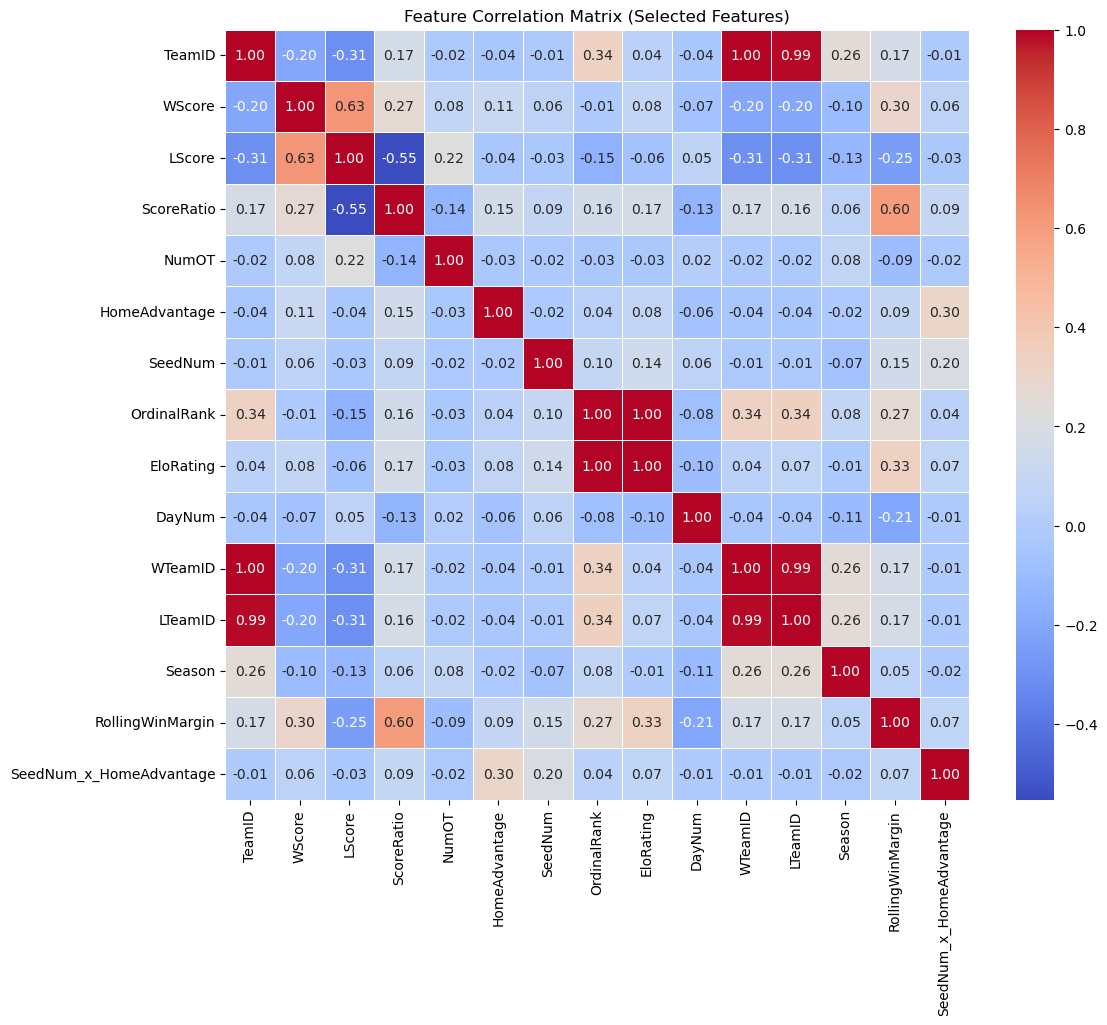

{'EloRating', 'LTeamID', 'WTeamID'}

In [169]:
# Selecting the final set of important features from the combined dataset

selected_features = [ 'TeamID',
    'WScore', 'LScore', 'ScoreRatio', 'NumOT', 'HomeAdvantage', 
    'SeedNum', 'OrdinalRank', 'EloRating', 'DayNum', 'WTeamID', 
    'LTeamID', 'Season', 'RollingWinMargin','SeedNum_x_HomeAdvantage'
]

# Create a new dataset with only the selected features
final_dataset = combined[selected_features]

# Compute correlation matrix for the selected features
correlation_matrix = final_dataset.corr()

# Display correlation matrix as a heatmap to visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix (Selected Features)")
plt.show()

# Identify highly correlated features (threshold > 0.8)
threshold = 0.8
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

highly_correlated_features


Best iteration: 99
Best score (logloss): 0.5064677812350135


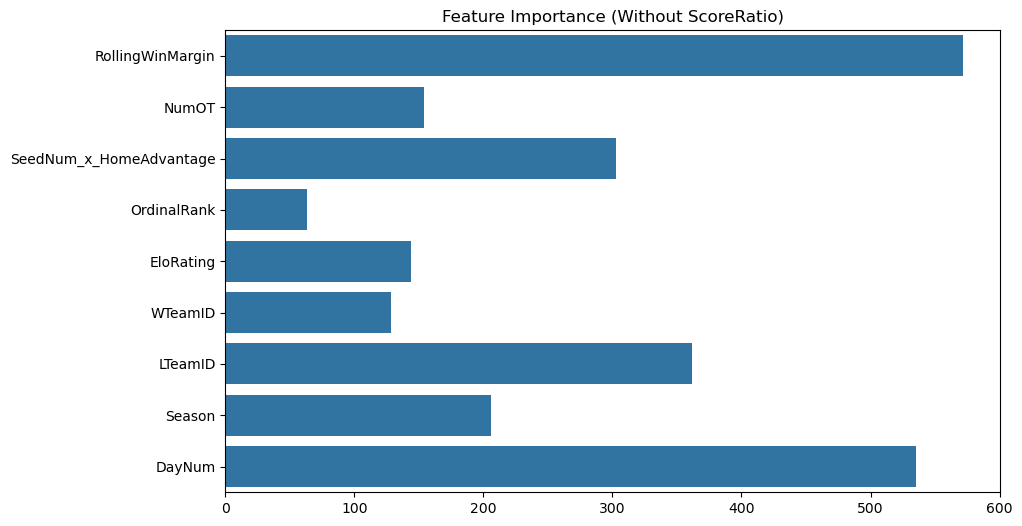

In [23]:
import xgboost as xgb
from sklearn.metrics import brier_score_loss
import numpy as np


X = combined[['RollingWinMargin', 'NumOT', 'SeedNum_x_HomeAdvantage',
                    'OrdinalRank', 'EloRating', 'WTeamID', 'LTeamID', 'Season',
                   'DayNum']]


# Define target variable
y = (combined['WScore'] > combined['LScore']).astype(int)

# Define DMatrix for XGBoost
dtrain = xgb.DMatrix(X, label=y)

# Define parameter grid
param_grid = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'gamma': 0.1,
    'reg_lambda': 1,       # L2 regularization
    'reg_alpha': 1,        # L1 regularization
    'objective': 'binary:logistic'
}

# Cross-validation using xgb.cv
cv_results = xgb.cv(
    params=param_grid,
    dtrain=dtrain,
    num_boost_round=100,
    nfold=3,
    metrics="logloss",         # Use logloss instead of brier directly
    early_stopping_rounds=10,
    seed=42
)

# Best score and best round
best_iteration = cv_results['test-logloss-mean'].idxmin()
best_score = cv_results['test-logloss-mean'].min()

print(f"Best iteration: {best_iteration}")
print(f"Best score (logloss): {best_score}")

# Fit the best model
best_model = xgb.train(
    params=param_grid,
    dtrain=dtrain,
    num_boost_round=best_iteration
)

# Feature importance
importance = best_model.get_score(importance_type='weight')

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=list(importance.values()), y=list(importance.keys()))
plt.title('Feature Importance (Without ScoreRatio)')
plt.show()


### Post Grid Search with nested CV - leveraged fine-tuned hyperparameters

In [30]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

# ==== Prepare Data ====
X = combined[['RollingWinMargin', 'NumOT', 'OrdinalRank', 'WTeamID', 'LTeamID', 'Season', 'DayNum', 'SeedNum_x_HomeAdvantage']]
y = (combined['WScore'] > combined['LScore']).astype(int)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==== Define Tuned Models ====
xgb = XGBClassifier(
    colsample_bytree=0.8,
    gamma=0.1,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=200,
    reg_alpha=0.1,
    reg_lambda=1,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

rf = RandomForestClassifier(
    max_depth=15,
    max_features='log2',
    min_samples_leaf=3,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

lgb = LGBMClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=10,
    num_leaves=31,
    reg_alpha=0.1,
    reg_lambda=0.1,
    subsample=0.8,
    random_state=42
)

# ==== Stacking Classifier ====
stacked_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rf),
        ('lgb', lgb)
    ],
    final_estimator=LogisticRegression(max_iter=500),
    passthrough=True,
    n_jobs=-1
)

# ==== Fit Stacking Model ====
stacked_clf.fit(X_train, y_train)

# ==== Predict and Evaluate ====
y_pred = stacked_clf.predict(X_test)
y_proba = stacked_clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Brier Score:", brier_score_loss(y_test, y_proba))
print("Log Loss:", log_loss(y_test, y_proba))

Accuracy: 0.7332472464868971
F1: 0.6548056696876168
Precision: 0.6859425841261996
Recall: 0.6263727997592899
ROC AUC: 0.8131419045615715
Brier Score: 0.1728147714944098
Log Loss: 0.5129612601091984


In [251]:
import pandas as pd
import numpy as np

# === Read Submission File ===
submission_file = "C:/Users/91788/march-mania/SampleSubmissionStage2.csv"
sample_submission = pd.read_csv(submission_file)

# === Split ID into Season, Team1, and Team2 ===
sample_submission[['Season', 'Team1', 'Team2']] = sample_submission['ID'].str.split('_', expand=True).astype(int)

# === Merge using Team1 ===
X_kaggle_1 = sample_submission.merge(
    combined,
    left_on=['Season', 'Team1'],
    right_on=['Season', 'WTeamID'],
    how='left'
)

# === Merge using Team2 ===
X_kaggle_2 = sample_submission.merge(
    combined,
    left_on=['Season', 'Team2'],
    right_on=['Season', 'LTeamID'],
    how='left'
)

# === Combine both matches ===
X_kaggle = pd.concat([X_kaggle_1, X_kaggle_2]).drop_duplicates(subset=['Season', 'Team1', 'Team2']).reset_index(drop=True)


In [253]:
# === Handle Missing Values ===
for col in ['RollingWinMargin', 'NumOT', 'OrdinalRank', 'SeedNum_x_HomeAdvantage']:
    if col in X_kaggle.columns:
        X_kaggle[col] = X_kaggle[col].fillna(combined.groupby('WTeamID')[col].transform('mean'))


In [255]:
# Fallback for remaining missing values
X_kaggle.fillna(-1, inplace=True)


In [257]:
# Drop existing LTeamID if it already exists
if 'LTeamID' in X_kaggle.columns:
    X_kaggle.drop('LTeamID', axis=1, inplace=True)

# Rename Team2 to LTeamID
X_kaggle = X_kaggle.rename(columns={'Team2': 'LTeamID'})



In [259]:
# === Predict probabilities ===
features = ['RollingWinMargin', 'NumOT', 'OrdinalRank', 'WTeamID', 'LTeamID', 'Season', 'DayNum', 'SeedNum_x_HomeAdvantage']


In [261]:
X_kaggle[features]

,RollingWinMargin,NumOT,OrdinalRank,WTeamID,LTeamID,Season,DayNum,SeedNum_x_HomeAdvantage
0,12.0,0,0.522989,1101,1102,2025,12,-1.0
1,12.0,0,0.522989,1101,1103,2025,12,-1.0
2,12.0,0,0.522989,1101,1104,2025,12,-1.0
3,12.0,0,0.522989,1101,1105,2025,12,-1.0
4,12.0,0,0.522989,1101,1106,2025,12,-1.0
...,...,...,...,...,...,...,...,...
131402,1.0,1,0.705253,3477,3479,2025,17,1.0
131403,1.0,1,0.705253,3477,3480,2025,17,1.0
131404,6.0,1,0.705253,3478,3479,2025,75,-1.0
131405,6.0,1,0.705253,3478,3480,2025,75,-1.0


In [264]:
 pred = stacked_clf.predict_proba(X_kaggle[features])[:, 1]

In [266]:
pred

array([0.28869191, 0.29172289, 0.30557133, ..., 0.01054622, 0.0105464 ,
       0.41342391])

In [268]:
# Ensure length consistency
sample_submission['Pred'] = pd.to_numeric(pred[:len(sample_submission)], errors='coerce')

In [270]:
# === Show Results ===
print(sample_submission[['ID', 'Pred']][sample_submission['Pred'] != 0.0].head(10))

               ID      Pred
0  2025_1101_1102  0.288692
1  2025_1101_1103  0.291723
2  2025_1101_1104  0.305571
3  2025_1101_1105  0.313511
4  2025_1101_1106  0.309559
5  2025_1101_1107  0.302706
6  2025_1101_1108  0.298303
7  2025_1101_1110  0.278396
8  2025_1101_1111  0.260528
9  2025_1101_1112  0.259801


In [272]:
# === Store Submission File ===
output_file = "submission2.csv"
sample_submission[['ID', 'Pred']].to_csv(output_file, index=False)

print(f"Submission file saved to: {output_file}")


Submission file saved to: submission2.csv
